---
title:  "Neuralnet Basic 05"
excerpt: "Basic Neural Net using numpy,tensor-flow,keras"

categories:
  - Deep-Learning
tags:
  - DL
  - Neuralnet Using keras
  - KEARS 창시자에게 배우는 딥러닝
  - 딥러닝
last_modified_at: 2020-03-04T23:06:00-05:00
---

KEARS 창시자에게 배우는 딥러닝 - 3장 -03 회귀문제
> 그동안 classfication 을 다루었다면, 여기서는 회귀문제를 다룬다.
> 회귀문제는 loss 함수로, 통상 MSE 를 많이 사용한다. 또한, 이번 예제와 같이, dataset 이 적을 경우, k-fold 방식으로도 어떻게 접근해서 해결하는지 확인해본다.  
> [책 관련 Blog 로 이동](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EC%B0%BD%EC%8B%9C%EC%9E%90%EC%97%90%EA%B2%8C-%EB%B0%B0%EC%9A%B0%EB%8A%94-%EB%94%A5%EB%9F%AC%EB%8B%9D/)


In [1]:
## local PC 에서, gpu 메모리를 다른 프로세서가 선점하고 있을때, 다시 설정해주는 코드임
import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.2.4'

In [3]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

### --------------------------------**데이터 내용 파악 start**--------------------------------------------------

In [4]:
print("train_data.shape",train_data.shape)
print("train_targets.shape",train_targets.shape)
print("test_data.shape",test_data.shape)
print("test_targets",test_targets.shape)

train_data.shape (404, 13)
train_targets.shape (404,)
test_data.shape (102, 13)
test_targets (102,)


In [5]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [6]:
train_targets[0]

15.2

일단 모든 data가 numeric으로 이루어져 있으며, 회귀문제로, 값을 추정하는 접근이 필요한다. 
유명한 Boston 주택가격 회귀 예측인데, 샘플갯수가 적다.  
여기서 볼 수 있듯이 404개의 훈련 샘플과 102개의 테스트 샘플이 있고 모두 13개의 수치 특성을 가지고 있습니다. 13개의 특성은 다음과 같습니다:  
1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

타깃은 주택의 중간 가격으로 천달러 단위입니다:

### --------------------------------**데이터 내용 파악 end**--------------------------------------------------

뉴메릭 데이터의 경우, scale이 각 변수마다 다르기 대문에 조정이 필요하다. 이는 모든분석에서 매우 중요한 전처리 과정이다. 데이터의 왜곡을 불러올수 있기 때문이다.

In [7]:
## 일반적인 방법으로는 standardzation 시킬수있다.
## train set sclae 조정
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
## test set scale 조정
test_data -= mean
test_data /= std

주의할점은 반드시 train set으로 구한, 데이터의 분포 (mean,std)로, test set에게 적용해줘야 한다.  
쉽게 생각해서, 훈련 데이터와 테스트 데이러르 각각 다른 스케일로 변환하게 되면, 훈련데이터에서 학습한 정보가 쓸모없게 되는 셈이다.  
실전에 투입하여 새로운 데이터에 대한 예측을 만들때도, 반드시 훈련데이터에서 계산한 값을 가지고 정규화해야 한다.

모델만들기  
일반적으로 훈련 데이터의 갯수가 적을수록 과대적합이 더 쉽게 일어나므로 **작은 모델을 사용**하는 것이 과대적합을 피하는 한 방법이다.  
k-fold 구현을 넣기 위해, 모델을 만드는 과정을 아래와 같이 함수화한다.

In [34]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1)) ## 마지막층은 하나의 유닛을 가지고 있고, 활성화 함수가 없다. (선형층이라고 부름) 전형적인 스칼라 회귀를 위한 네트웍 구조이다.
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

하기 식에서는 test_data, test_targets 는 둘다 사용하지 않는다. 온전히 train data만, validation 용으로 나누어서 사용할뿐.

In [35]:
import numpy as np

k=4
num_val_samples = len(train_data)//k ## 나누기 몫만 구하기
num_epochs = 100
all_score = []
for i in range(k):
    print('처리중인 폴드 #',i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
    val_mse,val_mae = model.evaluate(val_data,val_targets,verbose=0) ## validation 데이터 기준으로 평가한, loos 값과, metric 값 (여기선 mse)
    if val_mse==val_mae:
        print('kiss')
    all_score.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [36]:
## numpy 의 c_ 결합은 axis=1 로 결합한다. 위와는 다르다. 여기서 _c 에서, axis=1 넣으면 에러남
## 상세한 내용은 내 BLOG의 다른글을 보면된다.
np.c_[np.array([1,2,3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [37]:
np.mean(all_score)

2.4378505316701267

Keras Callback 함수
콜백은 학습 과정의 특정 단계에서 적용할 함수의 세트입니다. 학습 과정 중 콜백을 사용해서 모델의 내적 상태와 통계자료를 확인 할 수 있습니다.  
콜백의 리스트는 (키워드 인수 callbacks로) Sequential이나 Model 클래스의 .fit() 메서드에 전달이 가능합니다. 그에 따라 학습의 각 단계에서 콜백의 적절한 메서드가 호출됩니다.  
[callback함수](https://keras.io/ko/callbacks/)

In [98]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [99]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    rslt = model.fit(partial_train_data, partial_train_targets, ## 모델 fit 결과를 history로 받음
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
#     print(type(rslt)) ## <class 'keras.callbacks.History'>
    history = rslt.history
#     print(type(history),history.keys())
    mae_history = history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


k fold 내 epoch 수(500) 만큼 .hisotory 객체에는 1회 epoch 가 끝났을때의, MAE 값을 찍음.  
따라서, all_mae_histories 에는 500 * 4  만큼의 mae 값이 있음. 각 cross-fold 별 평균을 구하자

In [100]:
print(type(all_mae_histories))
print(len(all_mae_histories),len(all_mae_histories[0]))

<class 'list'>
4 500


In [101]:
all_mae_histories[0][0],all_mae_histories[1][0],all_mae_histories[2][0],all_mae_histories[3][0]

(3.193030905015398, 4.005015722595819, 4.337651063900183, 5.760089798729019)

In [102]:
[[x[i] for x in all_mae_histories] for i in range(2)]

[[3.193030905015398, 4.005015722595819, 4.337651063900183, 5.760089798729019],
 [2.7652973609395546,
  3.0978137195700466,
  3.2400667077243916,
  3.745165466081978]]

In [103]:
## 상기 cell 의 결과로 볼때, 맨 뒤의 for 문이 맨 겉의 for 문이고 안쪽의 for 문이 inner loop 쪽의 for 문이다. 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] 

In [104]:
average_mae_history_01 = np.array(all_mae_histories).mean(axis=0)

In [105]:
average_mae_history[0] == average_mae_history_01[0]

True

In [106]:
import matplotlib.pyplot as plt

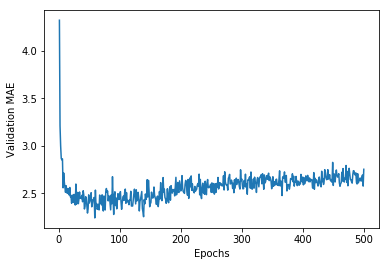

In [107]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### 지수이동평균을 활용해서, 다시 그려본다.
> 지수이동평균은 쉽게 얘기해서, 시계열 데이터에서 많이 사용하며, 특정 기간내의 값을 구할때  
가장 최신의 데이터가 좀더 가중치를 더 많이 영향을 줄 수 있도록 하는 것이다.

[지수이동평균 설명 Blog](https://m.blog.naver.com/PostView.nhn?blogId=gracekang7&logNo=221232491635&proxyReferer=https%3A%2F%2Fwww.google.com%2F)

하기 함수에서는 이전에 계산된 이동 평균에 factor를 곱하고, 현재 포인트에 (1-factor)를 곱해 합산한 것을 가르킨다.

In [108]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [109]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

490


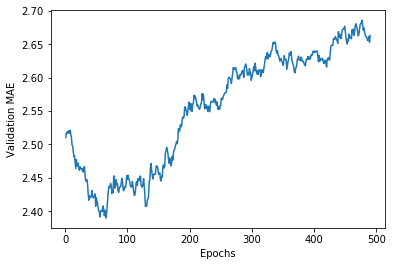

In [110]:
print(len(smooth_mae_history))
plt.clf()   # 그래프를 초기화합니다
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [112]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 509us/step


In [114]:
print(test_mse_score,test_mae_score)

19.117207994648055 2.951353344262815


1. 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용합니다. 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수입니다.
2. 비슷하게 회귀에서 사용되는 평가 지표는 분류와 다릅니다. 당연히 정확도 개념은 회귀에 적용되지 않습니다. 일반적인 회귀 지표는 평균 절대 오차(MAE)입니다.
3. 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 합니다.
4. 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 신뢰있게 평가 방법입니다.
5. 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층의 수를 줄인 모델이 좋습니다(일반적으로 하나 또는 두 개).